Fold 1: R²=0.918, RMSE=50.87, MAE=34.16
Fold 2: R²=0.919, RMSE=51.19, MAE=34.35
Fold 3: R²=0.914, RMSE=52.58, MAE=36.03
Fold 4: R²=0.925, RMSE=50.70, MAE=34.86
Fold 5: R²=0.915, RMSE=53.82, MAE=36.11

=== Average Model Performance Across 5 Folds ===
Average R²   : 0.918 ± 0.004
Average RMSE : 51.83 ± 1.20
Average MAE  : 35.10 ± 0.82


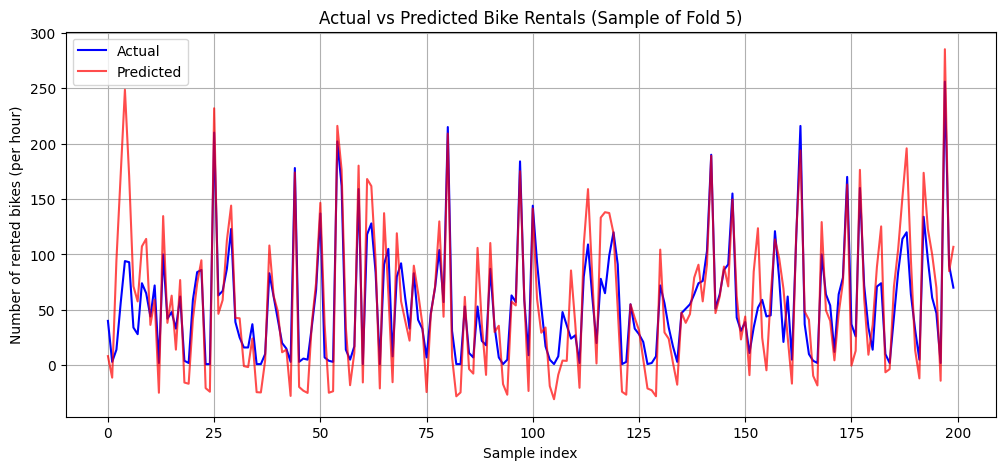

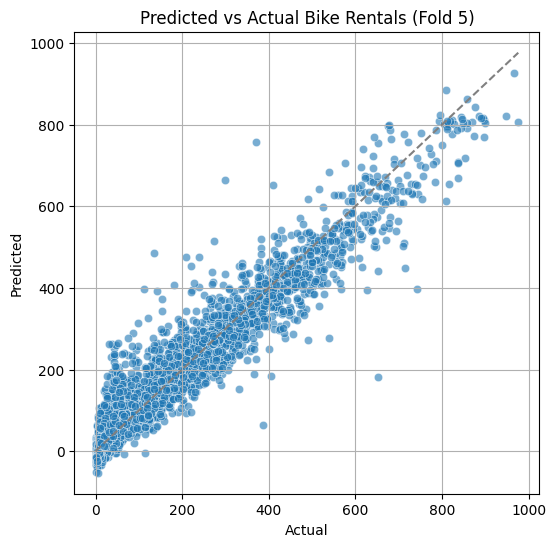


Predicted total bike rentals for this hour: 262


In [1]:


# --- 1. IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# --- 2. LOAD HOURLY DATASET ---
data = pd.read_csv("hour.csv")

# --- 3. SELECT RELEVANT FEATURES ---
# We include all context features that are predictive
data = data[['season','yr','mnth','hr','holiday','weekday','workingday',
             'weathersit','temp','atemp','hum','windspeed','cnt']]

# --- 4. SEPARATE FEATURES AND TARGET ---
X = data.drop(columns='cnt')
y = data['cnt']

# --- 5. ONE-HOT ENCODING ---
# Categorical features: season, mnth, hr, weekday, weathersit
categorical_cols = ['season','mnth','hr','weekday','weathersit']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- 6. SCALE NUMERICAL FEATURES ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# --- 7. K-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores, rmse_scores, mae_scores = [], [], []

fold = 1

# --- 8. TRAIN & EVALUATE MODEL ---
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Model configuration (tuned)
    model = GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=4,
        min_samples_leaf=2,
        subsample=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Fold {fold}: R²={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}")
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    fold += 1

# --- 9. AVERAGE PERFORMANCE ---
print("\n=== Average Model Performance Across 5 Folds ===")
print(f"Average R²   : {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"Average RMSE : {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")
print(f"Average MAE  : {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")

# --- 10. TRAIN FINAL MODEL ON FULL DATA ---
final_model = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)
final_model.fit(X_scaled, y)

# --- 11. VISUALIZATION (last fold as example) ---
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual", color='blue')
plt.plot(y_pred[:200], label="Predicted", color='red', alpha=0.7)
plt.title("Actual vs Predicted Bike Rentals (Sample of Fold 5)")
plt.xlabel("Sample index")
plt.ylabel("Number of rented bikes (per hour)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], '--', color='gray')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Bike Rentals (Fold 5)")
plt.grid(True)
plt.show()

# --- 12. TEST A SPECIFIC HOUR ---
# Example: Predict a clear summer weekday at 18:00
# season: 1=winter, 2=spring, 3=summer, 4=fall
# weathersit: 1=clear, 2=mist, 3=light rain, 4=heavy rain

test_hour = {
    'season': 3,     # summer
    'yr': 1,         # 2012
    'mnth': 7,       # July
    'hr': 18,        # 18:00
    'holiday': 0,
    'weekday': 2,    # Tuesday
    'workingday': 1,
    'weathersit': 1, # clear
    'temp': 0.7,     # normalized
    'atemp': 0.68,
    'hum': 0.55,
    'windspeed': 0.15
}

# Convert input to DataFrame
test_df = pd.DataFrame([test_hour])

# One-hot encode + align with training columns
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)
test_df = test_df.reindex(columns=X_encoded.columns, fill_value=0)

# Scale
test_scaled = scaler.transform(test_df)

# Predict
predicted_bikes = final_model.predict(test_scaled)[0]
print(f"\nPredicted total bike rentals for this hour: {predicted_bikes:.0f}")
